### Data Reading

# Live Job Aggregator Project

###Bronze Layer _ Ingesting Data to Databricks

In [0]:
import requests, json
from pyspark.sql import SparkSession 
from pyspark.sql.types import StructType, StructField, StringType

spark = SparkSession.builder.appName("JobETL_Bronze").getOrCreate()

# Setup catalog/schema (run this once)
spark.sql("CREATE CATALOG IF NOT EXISTS main")
spark.sql("USE CATALOG main")
spark.sql("CREATE SCHEMA IF NOT EXISTS bronze")
spark.sql("CREATE SCHEMA IF NOT EXISTS silver")
spark.sql("CREATE SCHEMA IF NOT EXISTS gold")

# Your existing code for API calls and DataFrame creation
API_KEY = "c79216ba9f9d5e98d3c3339cab4ed84ec83b15b662810fd5d4bf7ba6b544fd98"
roles = ["Data Engineer", "Python Developer", "ETL Developer", "Spark Engineer", "Data Analyst","AI Engineer","AI/ML Engineer"]
location = "India"
all_jobs = []

for role in roles:
    params = {
        "engine": "google_jobs",
        "q": role,
        "location": location,
        "api_key": API_KEY
    }
    res = requests.get("https://serpapi.com/search.json", params=params)
    print("✅Reading 🔴LIVE Data from Google Jobs API")
    jobs = res.json().get("jobs_results", [])
    
    for job in jobs:
        job["search_role"] = role
    all_jobs.extend(jobs)

schema = StructType([
    StructField("title", StringType(), True),
    StructField("company_name", StringType(), True),
    StructField("location", StringType(), True),
    StructField("description", StringType(), True),
    StructField("share_link", StringType(), True),
    StructField("search_role", StringType(), True)
])

bronze_df = spark.createDataFrame(all_jobs, schema=schema)

# Write to your bronze schema
bronze_df.write.format("delta").mode("append").saveAsTable("main.bronze.jobs_raw")

print("✅Data Written to Bronze Layer")

✅Reading 🔴LIVE Data from Google Jobs API
✅Reading 🔴LIVE Data from Google Jobs API
✅Reading 🔴LIVE Data from Google Jobs API
✅Reading 🔴LIVE Data from Google Jobs API
✅Reading 🔴LIVE Data from Google Jobs API
✅Reading 🔴LIVE Data from Google Jobs API
✅Reading 🔴LIVE Data from Google Jobs API
✅Data Written to Bronze Layer


In [0]:
display(bronze_df)

title company_name location description share_link search_role Data Engineer- Associate Federal Express Corporation AMEA Anywhere Responsible for developing, optimize, and maintaining business intelligence and data warehouse systems, ensuring secure, efficient data storage and retrieval, enabling self-service data exploration, and supporting stakeholders with insightful reporting and analysis.

1. Support the development and maintenance of business intelligence and analytics systems to support data-driven decision-making.
2. Implement of business intelligence and analytics systems, ensuring alignment with business requirements.
3. Design and optimize data warehouse architecture to support efficient storage and retrieval of large datasets.
4. Enable self-service data exploration capabilities for users to analyze and visualize data independently.
5. Develop reporting and analysis applications to generate insights from data for business stakeholders.
6. Design and implement data models to organize and structure data for analytical purposes.
7. Implement data security and federation strategies to ensure the confidentiality and integrity of sensitive information.
8. Optimize business intelligence production processes and adopt best practices to enhance efficiency and reliability.
9. Assist in training and support to users on business intelligence tools and applications.
10. Collaborate and maintain relationships with vendors and oversee project management activities to ensure timely and successful implementation of business intelligence solutions.

Education: Bachelor's degree or equivalent in Computer Science, MIS, Mathematics, Statistics, or similar discipline. Master's degree or PhD preferred.

Relevant work experience in data engineering based on the following number of years:
Standard I: Two (2) years
Standard II: Three (3) years
Senior I: Four (4) years
Senior II: Five (5) years

Knowledge, Skills and Abilities
• Fluency in English
• Analytical Skills
• Accuracy & Attention to Detail
• Numerical Skills
• Planning & Organizing Skills
• Presentation Skills
• Data Modeling and Database Design
• ETL (Extract, Transform, Load) Skills
• Programming Skills

FedEx was built on a philosophy that puts people first, one we take seriously. We are an equal opportunity/affirmative action employer and we are committed to a diverse, equitable, and inclusive workforce in which we enforce fair treatment, and provide growth opportunities for everyone.

All qualified applicants will receive consideration for employment regardless of age, race, color, national origin, genetics, religion, gender, marital status, pregnancy (including childbirth or a related medical condition), physical or mental disability, or any other characteristic protected by applicable laws, regulations, and ordinances.
Our Company

FedEx is one of the world's largest express transportation companies and has consistently been selected as one of the top 10 World’s Most Admired Companies by "Fortune" magazine. Every day FedEx delivers for its customers with transportation and business solutions, serving more than 220 countries and territories around the globe. We can serve this global network due to our outstanding team of FedEx team members, who are tasked with making every FedEx experience outstanding.
Our Philosophy

The People-Service-Profit philosophy (P-S-P) describes the principles that govern every FedEx decision, policy, or activity. FedEx takes care of our people; they, in turn, deliver the impeccable service demanded by our customers, who reward us with the profitability necessary to secure our future. The essential element in making the People-Service-Profit philosophy such a positive force for the company is where we close the circle, and return these profits back into the business, and invest back in our people. Our success in the industry is attributed to our people. Through our P-S-P philosophy, we have a work environment that encourages team members to be innov

##SILVER LAYER ---> Cleaning and Structuring

In [0]:
from pyspark.sql.functions import *

spark=SparkSession.builder.appName("JobETL_Silver").getOrCreate()

#reading Bronze Layer
print("✅Reading from Bronze Layer -------> Silver Layer")
df=spark.read.format("delta").table("main.bronze.jobs_raw")
silver_table_path = "main.silver.jobs_cleaned"
#cleaning and Structuring
silver_df=df.selectExpr(
    "title",
    "company_name",
    "location",
    "description",
    "share_link as job_link",  
    "search_role"
).dropna(subset=["title", "company_name", "location"])

✅Reading from Bronze Layer -------> Silver Layer


In [0]:
silver_df=silver_df.withColumn("company_name",trim(upper(col("company_name"))))
#silver_df=silver_df.dropna(subset=["posted_at"])
# Create temporary view for merge operation
#silver_updates.createOrReplaceTempView("updates")
# Writing to Silver Layer - Corrected approach
silver_df.write.format("delta") \
    .option("mergeSchema", "true") \
    .mode("append").saveAsTable("main.silver.jobs_cleaned")  # Changed from .save() to .saveAsTable()
# Changed from append to overwrite for idempotency
print("✅ Data Written to Silver Layer!")

✅ Data Written to Silver Layer!


##Golden LAYER ---> Generate KPI Tables


In [0]:
from pyspark.sql.functions import *

spark=SparkSession.builder.appName("JobETL_Gold").getOrCreate()

print("✅Reading from Silver Layer -------> Golden Layer")

df=spark.read.format("delta").table("main.silver.jobs_cleaned")

#writing the golden layer to a table 
df.write.format("delta").option("mergeSchema", "true").mode("append").saveAsTable("main.gold.jobs_final")
#KPI 1 - Top Companies 
top_companies = df.groupBy("company_name").count().orderBy(col("count").desc())
display(top_companies)

#KPI - Jobs by City 
companies_city=df.groupBy('Location').agg(count('*').alias('job_count')).orderBy(col('job_count').desc())
display(companies_city)

#KPI - Jobs by Role 
companies_role=df.groupBy('search_role').agg(count('*').alias('job_count')).orderBy(col('job_count').desc())
display(companies_role)

✅Reading from Silver Layer -------> Golden Layer


company_name count IN10 (FCRS = IN010) NOVARTIS HEALTHCARE PRIVATE LIMITED 6 BNP PARIBAS INDIA SOLUTIONS 6 VISA 6 QUALCOMM 6 EPAM SYSTEMS 6 KEYWORDS STUDIOS 6 THE IT FIRM 3 AKASHX 3 AERA TECHNOLOGY 3 ECOSMART ENERGY SYSTEM LLC 3 INFOSYS 3 ARMPL 3 EXPERIAN 3 BRAINIUM INFORMATION TECHNOLOGIES PVT. LTD. 3 STAFFINGINE LLC 3 BNP PARIBAS 3 NAGARRO 3 MATHWORKS 3 AVAYA 3 HITACHI CAREERS 3 SYNECHRON TECHNOLOGIES PVT. LTD._INDIA COMPANY 3 ALBIREO TECH SYSTEM 3 AMAZON 3 ICIMS TALENT ACQUISITION 3 EXXONMOBIL 3 MAERSK 3 BARCLAYS 3 A CLIENT OF ANALYTICS VIDHYA 3 NESTOR TECHNOLOGIES 3 TANISHA SYSTEMS INC 3 MCKINSEY & COMPANY 3 MINFY 3 ASTELLAS PHARMA 3 UNITEDHEALTH GROUP 3 FLUOR 3 IITJOBS INC 3 GIANTMIND SOLUTIONS 3 ALL EUROPEAN CAREERS 3 ASSA ABLOY 3 TIETOEVRY 3 HPE 3 D. E. SHAW INDIA 3 MOTIVE 3 ZOOM 3 DUPONT 3 FEDERAL EXPRESS CORPORATION AMEA 3 INSIGHT GLOBAL 3 ZENSAR TECHNOLOGIES 3 PERIMATTIC 3 E902 DWS INDIA PRIVATE LIMITED, MAHARASHTRA BRANCH 3 CODECRAFT TECHNOLOGIES 3 5100 KYNDRYL SOLUTIONS PRIVATE LIMITED 3 THE VALUE MAXIMIZER 3 MASTERCARD 3 MICROSTRATEGY 3 ADOBE 3 HIREGINIE 3 IND201 REFINITIV INDIA SHARED SERVICES PRIVATE LIMITED 3 EXAMROOM.AI 3 SAPLING INFOSYSTEMS 3 MSCI 3 AT&T 3 UBER 3 BRILLIANTECH SOFTWARE 3

Location job_count India 63 Hyderabad, Telangana, India 33 Anywhere 27 Pune, Maharashtra, India 24 Bengaluru, Karnataka, India 21 Chennai, Tamil Nadu, India 6 Mumbai, Maharashtra, India 6 Maharashtra, India 3 Gurugram, Haryana, India (+1 other) 3 Madhavaram, Telangana, India 3 Bhopal, Madhya Pradesh, India 3 Karnataka, India 3 Rai Durg, Telangana, India 3 Secunderabad, Telangana, India 3 India (+3 others) 3 Bengaluru, Karnataka, India (+1 other) 3 New Delhi, Delhi, India 3

search_role job_count ETL Developer 30 Spark Engineer 30 Data Engineer 30 Data Analyst 30 AI Engineer 30 AI/ML Engineer 30 Python Developer 30

In [0]:
from pyspark.sql.functions import *

spark=SparkSession.builder.appName("JobETL_Gold").getOrCreate()

df=spark.read.format("delta").table("main.gold.jobs_final")
df.write.mode("append").saveAsTable("JobAggregatorTable")
print("✅Data Successfully Written to Table ---> JobAggregatorTable")

✅Data Successfully Written to Table ---> JobAggregatorTable


In [0]:
%sql 
describe history JobAggregatorTable

version timestamp userId userName operation operationParameters job notebook clusterId readVersion isolationLevel isBlindAppend operationMetrics userMetadata engineInfo 0 2025-08-15T20:36:29.000Z 3151911771597054 parth.shrivastava51@gmail.com CREATE TABLE AS SELECT Map(partitionBy -> [], clusterBy -> [], description -> null, isManaged -> true, properties -> {"delta.enableDeletionVectors":"true"}, statsOnLoad -> true) null null 0815-193101-vkp42dup-v2n null WriteSerializable true Map(numFiles -> 1, numOutputRows -> 630, numOutputBytes -> 162446) null Databricks-Runtime/17.0.x-aarch64-photon-scala2.13

In [0]:
%sql
select * from JobAggregatorTable

title company_name location description job_link search_role Data Engineer- Associate FEDERAL EXPRESS CORPORATION AMEA Anywhere Responsible for developing, optimize, and maintaining business intelligence and data warehouse systems, ensuring secure, efficient data storage and retrieval, enabling self-service data exploration, and supporting stakeholders with insightful reporting and analysis.

1. Support the development and maintenance of business intelligence and analytics systems to support data-driven decision-making.
2. Implement of business intelligence and analytics systems, ensuring alignment with business requirements.
3. Design and optimize data warehouse architecture to support efficient storage and retrieval of large datasets.
4. Enable self-service data exploration capabilities for users to analyze and visualize data independently.
5. Develop reporting and analysis applications to generate insights from data for business stakeholders.
6. Design and implement data models to organize and structure data for analytical purposes.
7. Implement data security and federation strategies to ensure the confidentiality and integrity of sensitive information.
8. Optimize business intelligence production processes and adopt best practices to enhance efficiency and reliability.
9. Assist in training and support to users on business intelligence tools and applications.
10. Collaborate and maintain relationships with vendors and oversee project management activities to ensure timely and successful implementation of business intelligence solutions.

Education: Bachelor's degree or equivalent in Computer Science, MIS, Mathematics, Statistics, or similar discipline. Master's degree or PhD preferred.

Relevant work experience in data engineering based on the following number of years:
Standard I: Two (2) years
Standard II: Three (3) years
Senior I: Four (4) years
Senior II: Five (5) years

Knowledge, Skills and Abilities
• Fluency in English
• Analytical Skills
• Accuracy & Attention to Detail
• Numerical Skills
• Planning & Organizing Skills
• Presentation Skills
• Data Modeling and Database Design
• ETL (Extract, Transform, Load) Skills
• Programming Skills

FedEx was built on a philosophy that puts people first, one we take seriously. We are an equal opportunity/affirmative action employer and we are committed to a diverse, equitable, and inclusive workforce in which we enforce fair treatment, and provide growth opportunities for everyone.

All qualified applicants will receive consideration for employment regardless of age, race, color, national origin, genetics, religion, gender, marital status, pregnancy (including childbirth or a related medical condition), physical or mental disability, or any other characteristic protected by applicable laws, regulations, and ordinances.
Our Company

FedEx is one of the world's largest express transportation companies and has consistently been selected as one of the top 10 World’s Most Admired Companies by "Fortune" magazine. Every day FedEx delivers for its customers with transportation and business solutions, serving more than 220 countries and territories around the globe. We can serve this global network due to our outstanding team of FedEx team members, who are tasked with making every FedEx experience outstanding.
Our Philosophy

The People-Service-Profit philosophy (P-S-P) describes the principles that govern every FedEx decision, policy, or activity. FedEx takes care of our people; they, in turn, deliver the impeccable service demanded by our customers, who reward us with the profitability necessary to secure our future. The essential element in making the People-Service-Profit philosophy such a positive force for the company is where we close the circle, and return these profits back into the business, and invest back in our people. Our success in the industry is attributed to our people. Through our P-S-P philosophy, we have a work environment that encourages team members to be innovat

##Data Analytics Part -: Visualising Business Scenrios

In [0]:
import matplotlib.pyplot as plt
spark = SparkSession.builder.appName("VisualsFromGold").getOrCreate()

In [0]:
# Load gold layer: top companies
df_companies = spark.read.format("delta").table("main.gold.jobs_final")
#df_companies=df_companies.dropna(subset=["posted_at"])
display(df_companies)

title company_name location description job_link search_role Data Engineer- Associate FEDERAL EXPRESS CORPORATION AMEA Anywhere Responsible for developing, optimize, and maintaining business intelligence and data warehouse systems, ensuring secure, efficient data storage and retrieval, enabling self-service data exploration, and supporting stakeholders with insightful reporting and analysis.

1. Support the development and maintenance of business intelligence and analytics systems to support data-driven decision-making.
2. Implement of business intelligence and analytics systems, ensuring alignment with business requirements.
3. Design and optimize data warehouse architecture to support efficient storage and retrieval of large datasets.
4. Enable self-service data exploration capabilities for users to analyze and visualize data independently.
5. Develop reporting and analysis applications to generate insights from data for business stakeholders.
6. Design and implement data models to organize and structure data for analytical purposes.
7. Implement data security and federation strategies to ensure the confidentiality and integrity of sensitive information.
8. Optimize business intelligence production processes and adopt best practices to enhance efficiency and reliability.
9. Assist in training and support to users on business intelligence tools and applications.
10. Collaborate and maintain relationships with vendors and oversee project management activities to ensure timely and successful implementation of business intelligence solutions.

Education: Bachelor's degree or equivalent in Computer Science, MIS, Mathematics, Statistics, or similar discipline. Master's degree or PhD preferred.

Relevant work experience in data engineering based on the following number of years:
Standard I: Two (2) years
Standard II: Three (3) years
Senior I: Four (4) years
Senior II: Five (5) years

Knowledge, Skills and Abilities
• Fluency in English
• Analytical Skills
• Accuracy & Attention to Detail
• Numerical Skills
• Planning & Organizing Skills
• Presentation Skills
• Data Modeling and Database Design
• ETL (Extract, Transform, Load) Skills
• Programming Skills

FedEx was built on a philosophy that puts people first, one we take seriously. We are an equal opportunity/affirmative action employer and we are committed to a diverse, equitable, and inclusive workforce in which we enforce fair treatment, and provide growth opportunities for everyone.

All qualified applicants will receive consideration for employment regardless of age, race, color, national origin, genetics, religion, gender, marital status, pregnancy (including childbirth or a related medical condition), physical or mental disability, or any other characteristic protected by applicable laws, regulations, and ordinances.
Our Company

FedEx is one of the world's largest express transportation companies and has consistently been selected as one of the top 10 World’s Most Admired Companies by "Fortune" magazine. Every day FedEx delivers for its customers with transportation and business solutions, serving more than 220 countries and territories around the globe. We can serve this global network due to our outstanding team of FedEx team members, who are tasked with making every FedEx experience outstanding.
Our Philosophy

The People-Service-Profit philosophy (P-S-P) describes the principles that govern every FedEx decision, policy, or activity. FedEx takes care of our people; they, in turn, deliver the impeccable service demanded by our customers, who reward us with the profitability necessary to secure our future. The essential element in making the People-Service-Profit philosophy such a positive force for the company is where we close the circle, and return these profits back into the business, and invest back in our people. Our success in the industry is attributed to our people. Through our P-S-P philosophy, we have a work environment that encourages team members to be innovat

In [0]:
# Convert to Pandas for plotting
pdf = df_companies.orderBy("company_name", ascending=True).limit(10).toPandas()

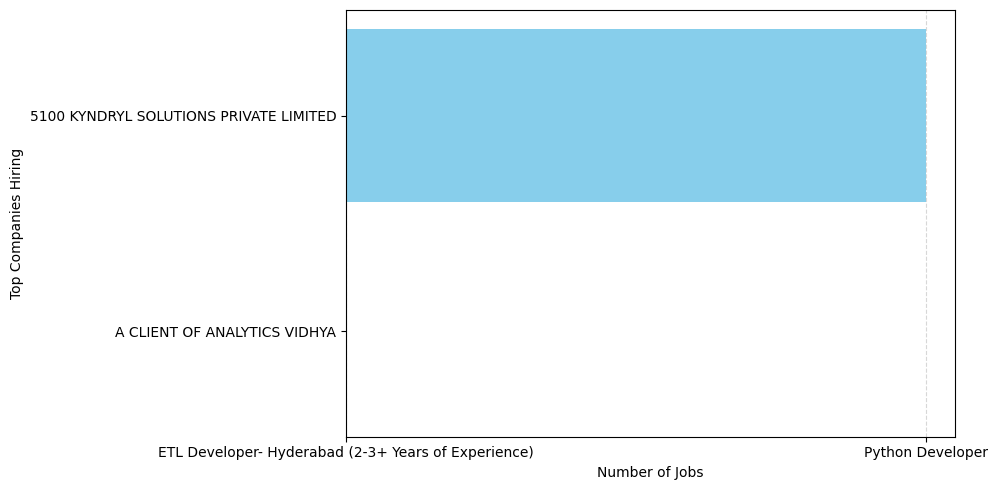

In [0]:
#creating a plot
plt.figure(figsize=(10,5))
plt.barh(pdf['company_name'][::-1], pdf['title'][::-1], color='skyblue')
plt.xlabel('Number of Jobs')
plt.ylabel('Top Companies Hiring')
plt.grid(True,axis='x',linestyle='--',alpha=0.5)
plt.tight_layout()
plt.show()

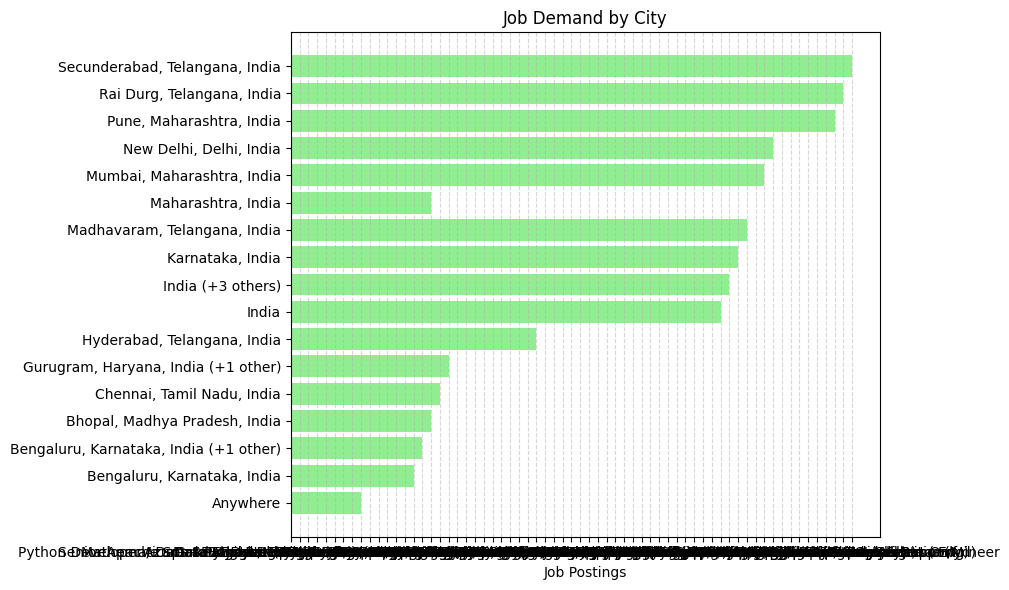

In [0]:
df_cities = spark.read.format("delta").table("main.gold.jobs_final")
#df_cities=df_cities.dropna(subset=["posted_at"])
pdf_city = df_cities.orderBy("location", ascending=False).toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.barh(pdf_city['location'][::-1], pdf_city['title'][::-1], color='lightgreen')
plt.xlabel("Job Postings")
plt.title("Job Demand by City")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
     